In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import errno
import sys




import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import sampler
import torchvision.transforms as T


#import help_func
#import new_ALL_Conv

In [2]:
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
NUM_TRAIN=49000
train_batch_size=4
test_batch_size=4


cifar10_train = torchvision.datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = torch.utils.data.DataLoader(cifar10_train, batch_size=train_batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = torchvision.datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = torch.utils.data.DataLoader(cifar10_val, batch_size=train_batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = torchvision.datasets.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = torch.utils.data.DataLoader(cifar10_test, batch_size=test_batch_size)





Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torchvision.datasets as dset
from PIL import Image    
import os
import os.path
import errno
import sys
import torch

class CIFAR100(dset.CIFAR10):

    base_folder = '.'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    
    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        self.test_data = []
        if self.train:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((5000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            print(self.train_data.shape)
        else:
            f = 'test'
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = np.array(entry['data'])
            if 'labels' in entry:
                self.test_labels = entry['data']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((1000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC
            print(self.test_data.shape)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.astype('uint8')).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)                
            
    def _check_integrity(self):
        return True
    


if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

A_train = CIFAR100('./class1', train=True, download=False,
                             transform=transform)
loaderA_train = torch.utils.data.DataLoader(A_train, batch_size=4)



A_test = CIFAR100('./class1', train=False, download=False,
                             transform=transform)
loaderA_test = torch.utils.data.DataLoader(A_test, batch_size=4)


B_train = CIFAR100('./class2', train=True, download=False,
                             transform=transform)
loaderB_train = torch.utils.data.DataLoader(B_train, batch_size=4)


B_test = CIFAR100('./class2', train=False, download=False,
                             transform=transform)
loaderB_test = torch.utils.data.DataLoader(B_test, batch_size=4)
   


(5000, 32, 32, 3)
(1000, 32, 32, 3)
(5000, 32, 32, 3)
(1000, 32, 32, 3)


In [4]:
class Stride_CNN_C(nn.Module):
    def __init__(self, num_classes=10):
        super (Stride_CNN_C, self).__init__()
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=0)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)
        
        
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.constant_(self.conv3.bias, 0)
        
        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.constant_(self.conv4.bias, 0)
        
       
        self.dropout3 = nn.Dropout(0.5)
        
        self.conv5 = nn.Conv2d(192, 192, kernel_size=3, padding=3)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.constant_(self.conv5.bias, 0)
        
        self.conv6 = nn.Conv2d(192, 192, kernel_size=1)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.constant_(self.conv6.bias, 0)
        
        self.conv7 = nn.Conv2d(192, self.num_classes, kernel_size=1)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.constant_(self.conv7.bias, 0)
        
        self.glb_avg = nn.AvgPool2d(6)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        
        
        out = self.dropout2(out)
        
        out = self.conv3(out)
        out = F.relu(out)
        
        out = self.conv4(out)
        out = F.relu(out)
        
        out = self.dropout3(out)
        
        out = self.conv5(out)
        out = F.relu(out)
        
        out = self.conv6(out)
        out = F.relu(out)
        
        out = self.conv7(out)
        out = F.relu(out)
        
        out = self.glb_avg(out)
        out = out.view(-1, self.num_classes)
        return out
import new_ALL_Conv
stride_cnn_c = new_ALL_Conv.Stride_CNN_C()

right


In [10]:
from six.moves import cPickle
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import sampler

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples *100
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples,  acc))
    return acc*100

def running_model_B(run_num, net, net_name, lr_list, epoch_list, loader_train, 
                   loader_test):
    train_batch_size = 4
    test_batch_size = 4
    

    # Constant to control how frequently we print train loss
    print_every = 100

    print('using device:', device)
    
    #net = BaseNet_A()
    net = net.to(device=device)
    criterion = nn.CrossEntropyLoss()        
        
    lr_1, lr_2, lr_3, lr_4 = lr_list[0], lr_list[1], lr_list[2], lr_list[3]
    weight_decay = 0.001

    max_epoch = 350
    display_interval = 500

    train_size = 5000
    test_size = 1000

    num_train_batch = train_size/train_batch_size
    num_test_batch = test_size/test_batch_size

    train_loss = np.zeros((max_epoch,1))
    val_acc = np.zeros((max_epoch,1))
    #train_acc = np.zeros((max_epoch,1))
    #test_loss = np.zeros((max_epoch,1))
    #test_acc = np.zeros((max_epoch,1))

    epoch_acc = [] # max_epoch x num
    print("begin training")
    for epoch in range(max_epoch):
        if(epoch<epoch_list[0]):
            lr = lr_1
        elif(epoch<epoch_list[1]):
            lr = lr_2
        elif(epoch<epoch_list[2]):
            lr = lr_3
        else:
            lr = lr_4
    
        optimizer = optim.SGD( net.parameters(), lr=0.001,
                              momentum=0.9, weight_decay=weight_decay)
    
        running_epoch_loss = 0.
        running_loss_print = 0.
        epoch_total_num = 0
        correct_num = 0
    
        i_acc = []
        #for i, data in enumerate(trainloader):
        for i, data in enumerate(loader_train):
            net.train()
        
            inputs_data, labels_data = data
            inputs, labels = Variable(inputs_data), Variable(labels_data)
            inputs = inputs.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
        
    
        
        
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_epoch_loss += loss.item()
            running_loss_print += loss.item()
            if i%500 == 499: #net a, b, c 500 print once
                
                acc = check_accuracy(loader_test, net)
                i_acc.append(acc)
                print('%d epoch, %5d iteration, loss:%.3f' 
                      %(epoch+1, i+1, running_loss_print/1000) )
                running_loss_print = 0.
            
            #_, pred = torch.max(outputs, 1)
            #epoch_total_num += labels.size(0)
            #correct_num += (pred==labels).sum()
        
        
        train_loss[epoch] = running_epoch_loss/num_train_batch
        epoch_acc.append(i_acc)
        
        val_acc[epoch] = np.sum(epoch_acc[epoch])/49
        #val_acc[epoch] = np.sum(epoch_acc[epoch])
        #train_acc[epoch] = correct_num/epoch_total_num*100
    
    
        # test accuracy and loss
        '''
        ts_runningloss_epoch = 0.
        ts_correct = 0
        ts_epoch_num = 0
        for data in testloader:
            inputs_data, labels_data = data
            inputs, labels = Variable(inputs_data), Variable(labels_data)
            inputs = inputs.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
        
            net.eval()
            ts_outputs = net(inputs)
            loss = criterion(outputs, labels)
        
            ts_runningloss_epoch += loss.item()
            _, ts_pred = torch.max(ts_outputs, 1)
        
            ts_epoch_num += labels.size(0)
            ts_correct += (ts_pred==labels).sum()
        test_loss[epoch] = ts_runningloss_epoch/num_test_batch
        test_acc[epoch] = ts_correct/ts_epoch_num*100
        '''
        print(" num %d epoch " %epoch)
        print("####### Training Loss #######")
        print(train_loss[epoch])
        #print("####### Validation Accuracy #######")
        #print(val_acc[epoch])
        #print("####### Training Accuracy #######")
        #print(train_acc[epoch])
        #print("####### Testing Loss #######")
        #print(test_loss[epoch])
        #print("####### Testing Accuracy #######")
        #print(test_acc[epoch])
    
    print('finish training \n')

    



##################################################################################################
    print('now begin saving datum for next step plotting')
    
    save_path = '../datum_for_plotting/run_num_' + str(run_num)+'/'+ net_name
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    f = open(save_path + '/train_loss.save', 'wb')
    cPickle.dump(train_loss, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    f = open(save_path + '/val_acc.save', 'wb')
    cPickle.dump(val_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    f = open(save_path + '/epoch_acc.save', 'wb')
    cPickle.dump(epoch_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    array_epoch_acc = np.array(epoch_acc)
    f = open(save_path + '/array_epoch_acc.save', 'wb')
    cPickle.dump(array_epoch_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

    #f = open(save_path + '/test_acc.save', 'wb')
    #cPickle.dump(test_acc, f, protocol=cPickle.HIGHEST_PROTOCOL)
    #f.close()



    torch.save(net, save_path+'/'+ net_name +'.pkl') # save whole net structure and params
    torch.save(net.state_dict, save_path+'/'+ net_name +'_params.pkl') # only save model params
 
    
    
    
##################################################################################################    
    print("now plotting accuracies and losses")  
    itern_axis_train = np.array(np.linspace(1,max_epoch,num=max_epoch))
    itern_axis_test = np.array(np.linspace(1,max_epoch, num=max_epoch))

    plt.plot(itern_axis_train, train_loss,'-b.', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.savefig(save_path + '/train_loss' + str(max_epoch) + '.png')
    
    a = np.concatenate(array_epoch_acc)
    length = a.shape[0]
    plt.plot(length, a, '--r', label='Test')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.savefig(save_path + '/testing_accuracy' + str(max_epoch) + '.png')
    
    return net

    

using device: cuda
begin training
Checking accuracy on test set
Got 147 / 1000 correct (14.70)
1 epoch,   500 iteration, loss:1.152
Checking accuracy on test set
Got 165 / 1000 correct (16.50)
1 epoch,  1000 iteration, loss:1.149
 num 0 epoch 
####### Training Loss #######
[2.2961514]
Checking accuracy on test set
Got 259 / 1000 correct (25.90)
2 epoch,   500 iteration, loss:1.110
Checking accuracy on test set
Got 259 / 1000 correct (25.90)
2 epoch,  1000 iteration, loss:1.083
 num 1 epoch 
####### Training Loss #######
[2.17632085]
Checking accuracy on test set
Got 293 / 1000 correct (29.30)
3 epoch,   500 iteration, loss:1.033
Checking accuracy on test set
Got 314 / 1000 correct (31.40)
3 epoch,  1000 iteration, loss:1.026
 num 2 epoch 
####### Training Loss #######
[2.04469434]
Checking accuracy on test set
Got 335 / 1000 correct (33.50)
4 epoch,   500 iteration, loss:0.996
Checking accuracy on test set
Got 337 / 1000 correct (33.70)
4 epoch,  1000 iteration, loss:0.997
 num 3 epoch

Checking accuracy on test set
Got 634 / 1000 correct (63.40)
33 epoch,   500 iteration, loss:0.428
Checking accuracy on test set
Got 640 / 1000 correct (64.00)
33 epoch,  1000 iteration, loss:0.411
 num 32 epoch 
####### Training Loss #######
[0.82390486]
Checking accuracy on test set
Got 658 / 1000 correct (65.80)
34 epoch,   500 iteration, loss:0.411
Checking accuracy on test set
Got 637 / 1000 correct (63.70)
34 epoch,  1000 iteration, loss:0.404
 num 33 epoch 
####### Training Loss #######
[0.79793177]
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
35 epoch,   500 iteration, loss:0.394
Checking accuracy on test set
Got 647 / 1000 correct (64.70)
35 epoch,  1000 iteration, loss:0.395
 num 34 epoch 
####### Training Loss #######
[0.76979165]
Checking accuracy on test set
Got 644 / 1000 correct (64.40)
36 epoch,   500 iteration, loss:0.384
Checking accuracy on test set
Got 667 / 1000 correct (66.70)
36 epoch,  1000 iteration, loss:0.382
 num 35 epoch 
####### Training Lo

Got 690 / 1000 correct (69.00)
65 epoch,   500 iteration, loss:0.167
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
65 epoch,  1000 iteration, loss:0.189
 num 64 epoch 
####### Training Loss #######
[0.34476063]
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
66 epoch,   500 iteration, loss:0.168
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
66 epoch,  1000 iteration, loss:0.172
 num 65 epoch 
####### Training Loss #######
[0.33270323]
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
67 epoch,   500 iteration, loss:0.180
Checking accuracy on test set
Got 671 / 1000 correct (67.10)
67 epoch,  1000 iteration, loss:0.164
 num 66 epoch 
####### Training Loss #######
[0.33383038]
Checking accuracy on test set
Got 657 / 1000 correct (65.70)
68 epoch,   500 iteration, loss:0.173
Checking accuracy on test set
Got 647 / 1000 correct (64.70)
68 epoch,  1000 iteration, loss:0.175
 num 67 epoch 
####### Training Loss #######
[0.33228206]
Checki

Checking accuracy on test set
Got 662 / 1000 correct (66.20)
97 epoch,  1000 iteration, loss:0.102
 num 96 epoch 
####### Training Loss #######
[0.19448034]
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
98 epoch,   500 iteration, loss:0.093
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
98 epoch,  1000 iteration, loss:0.100
 num 97 epoch 
####### Training Loss #######
[0.1913845]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
99 epoch,   500 iteration, loss:0.100
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
99 epoch,  1000 iteration, loss:0.094
 num 98 epoch 
####### Training Loss #######
[0.19422606]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
100 epoch,   500 iteration, loss:0.095
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
100 epoch,  1000 iteration, loss:0.078
 num 99 epoch 
####### Training Loss #######
[0.17310048]
Checking accuracy on test set
Got 664 / 1000 correct (66.40)
101 epoch,   

Got 655 / 1000 correct (65.50)
129 epoch,   500 iteration, loss:0.073
Checking accuracy on test set
Got 661 / 1000 correct (66.10)
129 epoch,  1000 iteration, loss:0.070
 num 128 epoch 
####### Training Loss #######
[0.14299123]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
130 epoch,   500 iteration, loss:0.074
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
130 epoch,  1000 iteration, loss:0.070
 num 129 epoch 
####### Training Loss #######
[0.14168456]
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
131 epoch,   500 iteration, loss:0.073
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
131 epoch,  1000 iteration, loss:0.070
 num 130 epoch 
####### Training Loss #######
[0.14455018]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
132 epoch,   500 iteration, loss:0.071
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
132 epoch,  1000 iteration, loss:0.071
 num 131 epoch 
####### Training Loss #######
[0.1421

 num 159 epoch 
####### Training Loss #######
[0.12270385]
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
161 epoch,   500 iteration, loss:0.067
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
161 epoch,  1000 iteration, loss:0.065
 num 160 epoch 
####### Training Loss #######
[0.12679277]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
162 epoch,   500 iteration, loss:0.056
Checking accuracy on test set
Got 663 / 1000 correct (66.30)
162 epoch,  1000 iteration, loss:0.057
 num 161 epoch 
####### Training Loss #######
[0.11487569]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
163 epoch,   500 iteration, loss:0.057
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
163 epoch,  1000 iteration, loss:0.060
 num 162 epoch 
####### Training Loss #######
[0.11278151]
Checking accuracy on test set
Got 659 / 1000 correct (65.90)
164 epoch,   500 iteration, loss:0.051
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
164

Got 688 / 1000 correct (68.80)
192 epoch,  1000 iteration, loss:0.052
 num 191 epoch 
####### Training Loss #######
[0.10581699]
Checking accuracy on test set
Got 694 / 1000 correct (69.40)
193 epoch,   500 iteration, loss:0.043
Checking accuracy on test set
Got 671 / 1000 correct (67.10)
193 epoch,  1000 iteration, loss:0.051
 num 192 epoch 
####### Training Loss #######
[0.09598161]
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
194 epoch,   500 iteration, loss:0.060
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
194 epoch,  1000 iteration, loss:0.055
 num 193 epoch 
####### Training Loss #######
[0.11793477]
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
195 epoch,   500 iteration, loss:0.050
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
195 epoch,  1000 iteration, loss:0.048
 num 194 epoch 
####### Training Loss #######
[0.10155848]
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
196 epoch,   500 iteration, loss:

Checking accuracy on test set
Got 679 / 1000 correct (67.90)
224 epoch,  1000 iteration, loss:0.069
 num 223 epoch 
####### Training Loss #######
[0.1123435]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
225 epoch,   500 iteration, loss:0.063
Checking accuracy on test set
Got 658 / 1000 correct (65.80)
225 epoch,  1000 iteration, loss:0.055
 num 224 epoch 
####### Training Loss #######
[0.12080355]
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
226 epoch,   500 iteration, loss:0.057
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
226 epoch,  1000 iteration, loss:0.063
 num 225 epoch 
####### Training Loss #######
[0.11219526]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
227 epoch,   500 iteration, loss:0.051
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
227 epoch,  1000 iteration, loss:0.058
 num 226 epoch 
####### Training Loss #######
[0.10373717]
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
228 

Got 694 / 1000 correct (69.40)
256 epoch,   500 iteration, loss:0.045
Checking accuracy on test set
Got 665 / 1000 correct (66.50)
256 epoch,  1000 iteration, loss:0.051
 num 255 epoch 
####### Training Loss #######
[0.09874156]
Checking accuracy on test set
Got 690 / 1000 correct (69.00)
257 epoch,   500 iteration, loss:0.044
Checking accuracy on test set
Got 618 / 1000 correct (61.80)
257 epoch,  1000 iteration, loss:0.048
 num 256 epoch 
####### Training Loss #######
[0.10440614]
Checking accuracy on test set
Got 707 / 1000 correct (70.70)
258 epoch,   500 iteration, loss:0.048
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
258 epoch,  1000 iteration, loss:0.051
 num 257 epoch 
####### Training Loss #######
[0.09511678]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
259 epoch,   500 iteration, loss:0.053
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
259 epoch,  1000 iteration, loss:0.036
 num 258 epoch 
####### Training Loss #######
[0.0915

Checking accuracy on test set
Got 691 / 1000 correct (69.10)
288 epoch,   500 iteration, loss:0.049
Checking accuracy on test set
Got 677 / 1000 correct (67.70)
288 epoch,  1000 iteration, loss:0.042
 num 287 epoch 
####### Training Loss #######
[0.09384851]
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
289 epoch,   500 iteration, loss:0.040
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
289 epoch,  1000 iteration, loss:0.048
 num 288 epoch 
####### Training Loss #######
[0.09083735]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
290 epoch,   500 iteration, loss:0.040
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
290 epoch,  1000 iteration, loss:0.061
 num 289 epoch 
####### Training Loss #######
[0.09964341]
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
291 epoch,   500 iteration, loss:0.037
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
291 epoch,  1000 iteration, loss:0.043
 num 290 epoch 
#######

 num 318 epoch 
####### Training Loss #######
[0.08865211]
Checking accuracy on test set
Got 694 / 1000 correct (69.40)
320 epoch,   500 iteration, loss:0.041
Checking accuracy on test set
Got 671 / 1000 correct (67.10)
320 epoch,  1000 iteration, loss:0.048
 num 319 epoch 
####### Training Loss #######
[0.08891309]
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
321 epoch,   500 iteration, loss:0.047
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
321 epoch,  1000 iteration, loss:0.045
 num 320 epoch 
####### Training Loss #######
[0.09591152]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
322 epoch,   500 iteration, loss:0.041
Checking accuracy on test set
Got 657 / 1000 correct (65.70)
322 epoch,  1000 iteration, loss:0.052
 num 321 epoch 
####### Training Loss #######
[0.09472168]
Checking accuracy on test set
Got 684 / 1000 correct (68.40)
323 epoch,   500 iteration, loss:0.033
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
323

ValueError: x and y must have same first dimension, but have shapes (1,) and (700,)

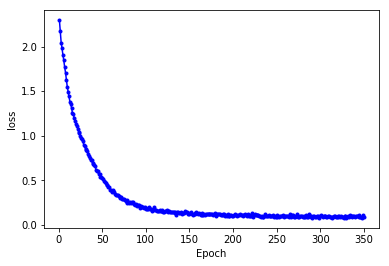

In [14]:
lr = [0.01, 0.005, 0.001, 0.0005]
epoch = [200, 250, 300] # first20

run_num = 10
net_name1 = 'Stride_CNN_C_Class1'

torch.cuda.set_device(1)
stride_cnn_c_class1 = new_ALL_Conv.Stride_CNN_C()
stride_cnn_c_class1 = running_model_B(run_num, stride_cnn_c_class1, net_name1, lr, epoch, 
                        loaderA_train, loaderA_test)

In [9]:
convpool_cnn_c_class2 = new_ALL_Conv.Stride_CNN_C()
net_name2 = 'ConvPool_CNN_C_Class2'
convpool_cnn_c_class2 = running_model_B(run_num, convpool_cnn_c_class2, net_name2, 
                        lr, epoch, loaderB_train, loaderB_test)

using device: cuda
begin training
Checking accuracy on test set
Got 170 / 1000 correct (17.00)
1 epoch,   500 iteration, loss:1.134
Checking accuracy on test set
Got 284 / 1000 correct (28.40)
1 epoch,  1000 iteration, loss:1.045
 num 0 epoch 
####### Training Loss #######
[2.13606516]
Checking accuracy on test set
Got 335 / 1000 correct (33.50)
2 epoch,   500 iteration, loss:0.953
Checking accuracy on test set
Got 375 / 1000 correct (37.50)
2 epoch,  1000 iteration, loss:0.896
 num 1 epoch 
####### Training Loss #######
[1.8232647]
Checking accuracy on test set
Got 429 / 1000 correct (42.90)
3 epoch,   500 iteration, loss:0.850
Checking accuracy on test set
Got 444 / 1000 correct (44.40)
3 epoch,  1000 iteration, loss:0.817
 num 2 epoch 
####### Training Loss #######
[1.64857017]
Checking accuracy on test set
Got 484 / 1000 correct (48.40)
4 epoch,   500 iteration, loss:0.793
Checking accuracy on test set
Got 462 / 1000 correct (46.20)
4 epoch,  1000 iteration, loss:0.768
 num 3 epoch

Got 649 / 1000 correct (64.90)
33 epoch,   500 iteration, loss:0.386
Checking accuracy on test set
Got 650 / 1000 correct (65.00)
33 epoch,  1000 iteration, loss:0.360
 num 32 epoch 
####### Training Loss #######
[0.74567557]
Checking accuracy on test set
Got 662 / 1000 correct (66.20)
34 epoch,   500 iteration, loss:0.392
Checking accuracy on test set
Got 630 / 1000 correct (63.00)
34 epoch,  1000 iteration, loss:0.359
 num 33 epoch 
####### Training Loss #######
[0.74192553]
Checking accuracy on test set
Got 645 / 1000 correct (64.50)
35 epoch,   500 iteration, loss:0.377
Checking accuracy on test set
Got 661 / 1000 correct (66.10)
35 epoch,  1000 iteration, loss:0.364
 num 34 epoch 
####### Training Loss #######
[0.7319085]
Checking accuracy on test set
Got 651 / 1000 correct (65.10)
36 epoch,   500 iteration, loss:0.375
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
36 epoch,  1000 iteration, loss:0.347
 num 35 epoch 
####### Training Loss #######
[0.71906193]
Checkin

Checking accuracy on test set
Got 674 / 1000 correct (67.40)
65 epoch,  1000 iteration, loss:0.165
 num 64 epoch 
####### Training Loss #######
[0.3368234]
Checking accuracy on test set
Got 671 / 1000 correct (67.10)
66 epoch,   500 iteration, loss:0.157
Checking accuracy on test set
Got 660 / 1000 correct (66.00)
66 epoch,  1000 iteration, loss:0.171
 num 65 epoch 
####### Training Loss #######
[0.33417476]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
67 epoch,   500 iteration, loss:0.162
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
67 epoch,  1000 iteration, loss:0.164
 num 66 epoch 
####### Training Loss #######
[0.32018879]
Checking accuracy on test set
Got 654 / 1000 correct (65.40)
68 epoch,   500 iteration, loss:0.154
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
68 epoch,  1000 iteration, loss:0.144
 num 67 epoch 
####### Training Loss #######
[0.30660885]
Checking accuracy on test set
Got 678 / 1000 correct (67.80)
69 epoch,   500

Got 690 / 1000 correct (69.00)
97 epoch,  1000 iteration, loss:0.096
 num 96 epoch 
####### Training Loss #######
[0.18861012]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
98 epoch,   500 iteration, loss:0.077
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
98 epoch,  1000 iteration, loss:0.095
 num 97 epoch 
####### Training Loss #######
[0.17498713]
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
99 epoch,   500 iteration, loss:0.088
Checking accuracy on test set
Got 707 / 1000 correct (70.70)
99 epoch,  1000 iteration, loss:0.088
 num 98 epoch 
####### Training Loss #######
[0.1785242]
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
100 epoch,   500 iteration, loss:0.085
Checking accuracy on test set
Got 682 / 1000 correct (68.20)
100 epoch,  1000 iteration, loss:0.092
 num 99 epoch 
####### Training Loss #######
[0.17084036]
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
101 epoch,   500 iteration, loss:0.079
Chec

Checking accuracy on test set
Got 707 / 1000 correct (70.70)
129 epoch,  1000 iteration, loss:0.064
 num 128 epoch 
####### Training Loss #######
[0.14221816]
Checking accuracy on test set
Got 689 / 1000 correct (68.90)
130 epoch,   500 iteration, loss:0.071
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
130 epoch,  1000 iteration, loss:0.063
 num 129 epoch 
####### Training Loss #######
[0.13489307]
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
131 epoch,   500 iteration, loss:0.075
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
131 epoch,  1000 iteration, loss:0.064
 num 130 epoch 
####### Training Loss #######
[0.14153645]
Checking accuracy on test set
Got 703 / 1000 correct (70.30)
132 epoch,   500 iteration, loss:0.063
Checking accuracy on test set
Got 722 / 1000 correct (72.20)
132 epoch,  1000 iteration, loss:0.078
 num 131 epoch 
####### Training Loss #######
[0.13129379]
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
133

Got 689 / 1000 correct (68.90)
161 epoch,   500 iteration, loss:0.059
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
161 epoch,  1000 iteration, loss:0.046
 num 160 epoch 
####### Training Loss #######
[0.10506526]
Checking accuracy on test set
Got 672 / 1000 correct (67.20)
162 epoch,   500 iteration, loss:0.060
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
162 epoch,  1000 iteration, loss:0.060
 num 161 epoch 
####### Training Loss #######
[0.11258161]
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
163 epoch,   500 iteration, loss:0.059
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
163 epoch,  1000 iteration, loss:0.058
 num 162 epoch 
####### Training Loss #######
[0.12478443]
Checking accuracy on test set
Got 680 / 1000 correct (68.00)
164 epoch,   500 iteration, loss:0.052
Checking accuracy on test set
Got 681 / 1000 correct (68.10)
164 epoch,  1000 iteration, loss:0.060
 num 163 epoch 
####### Training Loss #######
[0.1099

 num 191 epoch 
####### Training Loss #######
[0.09565709]
Checking accuracy on test set
Got 670 / 1000 correct (67.00)
193 epoch,   500 iteration, loss:0.058
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
193 epoch,  1000 iteration, loss:0.059
 num 192 epoch 
####### Training Loss #######
[0.11791696]
Checking accuracy on test set
Got 669 / 1000 correct (66.90)
194 epoch,   500 iteration, loss:0.049
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
194 epoch,  1000 iteration, loss:0.049
 num 193 epoch 
####### Training Loss #######
[0.1000282]
Checking accuracy on test set
Got 675 / 1000 correct (67.50)
195 epoch,   500 iteration, loss:0.057
Checking accuracy on test set
Got 702 / 1000 correct (70.20)
195 epoch,  1000 iteration, loss:0.039
 num 194 epoch 
####### Training Loss #######
[0.09834992]
Checking accuracy on test set
Got 703 / 1000 correct (70.30)
196 epoch,   500 iteration, loss:0.048
Checking accuracy on test set
Got 688 / 1000 correct (68.80)
196 

Got 695 / 1000 correct (69.50)
224 epoch,  1000 iteration, loss:0.049
 num 223 epoch 
####### Training Loss #######
[0.09500859]
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
225 epoch,   500 iteration, loss:0.044
Checking accuracy on test set
Got 694 / 1000 correct (69.40)
225 epoch,  1000 iteration, loss:0.045
 num 224 epoch 
####### Training Loss #######
[0.09280657]
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
226 epoch,   500 iteration, loss:0.047
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
226 epoch,  1000 iteration, loss:0.047
 num 225 epoch 
####### Training Loss #######
[0.09552701]
Checking accuracy on test set
Got 668 / 1000 correct (66.80)
227 epoch,   500 iteration, loss:0.062
Checking accuracy on test set
Got 695 / 1000 correct (69.50)
227 epoch,  1000 iteration, loss:0.061
 num 226 epoch 
####### Training Loss #######
[0.11311798]
Checking accuracy on test set
Got 676 / 1000 correct (67.60)
228 epoch,   500 iteration, loss:

Checking accuracy on test set
Got 701 / 1000 correct (70.10)
256 epoch,  1000 iteration, loss:0.050
 num 255 epoch 
####### Training Loss #######
[0.10572838]
Checking accuracy on test set
Got 700 / 1000 correct (70.00)
257 epoch,   500 iteration, loss:0.047
Checking accuracy on test set
Got 686 / 1000 correct (68.60)
257 epoch,  1000 iteration, loss:0.044
 num 256 epoch 
####### Training Loss #######
[0.09681078]
Checking accuracy on test set
Got 671 / 1000 correct (67.10)
258 epoch,   500 iteration, loss:0.046
Checking accuracy on test set
Got 667 / 1000 correct (66.70)
258 epoch,  1000 iteration, loss:0.048
 num 257 epoch 
####### Training Loss #######
[0.09377345]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
259 epoch,   500 iteration, loss:0.030
Checking accuracy on test set
Got 723 / 1000 correct (72.30)
259 epoch,  1000 iteration, loss:0.038
 num 258 epoch 
####### Training Loss #######
[0.07034246]
Checking accuracy on test set
Got 696 / 1000 correct (69.60)
260

Got 677 / 1000 correct (67.70)
288 epoch,   500 iteration, loss:0.044
Checking accuracy on test set
Got 693 / 1000 correct (69.30)
288 epoch,  1000 iteration, loss:0.048
 num 287 epoch 
####### Training Loss #######
[0.08915511]
Checking accuracy on test set
Got 687 / 1000 correct (68.70)
289 epoch,   500 iteration, loss:0.050
Checking accuracy on test set
Got 667 / 1000 correct (66.70)
289 epoch,  1000 iteration, loss:0.042
 num 288 epoch 
####### Training Loss #######
[0.08780626]
Checking accuracy on test set
Got 683 / 1000 correct (68.30)
290 epoch,   500 iteration, loss:0.040
Checking accuracy on test set
Got 713 / 1000 correct (71.30)
290 epoch,  1000 iteration, loss:0.047
 num 289 epoch 
####### Training Loss #######
[0.09052121]
Checking accuracy on test set
Got 698 / 1000 correct (69.80)
291 epoch,   500 iteration, loss:0.047
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
291 epoch,  1000 iteration, loss:0.048
 num 290 epoch 
####### Training Loss #######
[0.0947

 num 318 epoch 
####### Training Loss #######
[0.0857946]
Checking accuracy on test set
Got 679 / 1000 correct (67.90)
320 epoch,   500 iteration, loss:0.042
Checking accuracy on test set
Got 685 / 1000 correct (68.50)
320 epoch,  1000 iteration, loss:0.039
 num 319 epoch 
####### Training Loss #######
[0.07852017]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
321 epoch,   500 iteration, loss:0.044
Checking accuracy on test set
Got 705 / 1000 correct (70.50)
321 epoch,  1000 iteration, loss:0.039
 num 320 epoch 
####### Training Loss #######
[0.0837071]
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
322 epoch,   500 iteration, loss:0.037
Checking accuracy on test set
Got 691 / 1000 correct (69.10)
322 epoch,  1000 iteration, loss:0.046
 num 321 epoch 
####### Training Loss #######
[0.08167249]
Checking accuracy on test set
Got 692 / 1000 correct (69.20)
323 epoch,   500 iteration, loss:0.044
Checking accuracy on test set
Got 701 / 1000 correct (70.10)
323 e

NameError: name 'test_acc' is not defined

In [11]:
from six.moves import cPickle

save_path = '../datum_for_plotting/run_num_10/ConvPool_CNN_C_Class2'
f =open(save_path + '/train_loss.save' , 'rb')
loss = cPickle.load(f )
f.close()
f =open(save_path + '/array_epoch_acc.save' , 'rb')
acc_array = cPickle.load(f )
f.close()

Text(0, 0.5, 'loss')

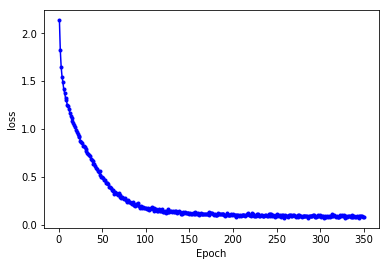

In [12]:
import matplotlib.pyplot as plt
max_epoch = 350
itern_axis_train = np.array(np.linspace(1,max_epoch,num=max_epoch))

plt.plot(itern_axis_train, loss,'-b.', label='Train')
plt.xlabel('Epoch')
plt.ylabel('loss')

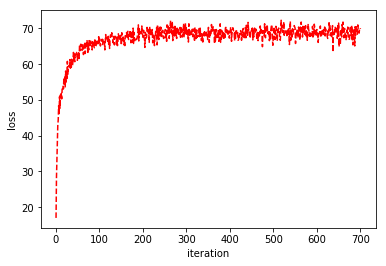

In [13]:
a = np.concatenate(acc_array)
length = a.shape[0]
a /= 100
acc_axis_test = np.array(np.linspace(1,length, num=length))
plt.plot(acc_axis_test, a.reshape(-1,1), '--r', label='Test')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(save_path + '/validation_accuracy' + str(max_epoch) + '.png')